<h1 align="center" style="color:#96d9f0;">Computational Intelligence for
Optimization - Project</h1>
<h3 align="center" style="color:#96d9f0;">Group AW - Wedding Seating Optimization</h3>

---

### <span style="color:#96d9f0;">Group Members</span>

<table>
  <thead style="color:#96d9f0;">
    <tr>
      <th>Name</th>
      <th>Email</th>
      <th>Student ID</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Afonso Dias</td>
      <td>20211540@novaims.unl.pt</td>
      <td>20211540</td>
    </tr>
    <tr>
      <td>Isabel Duarte</td>
      <td>20240545@novaims.unl.pt</td>
      <td>20240545</td>
    </tr>
    <tr>
      <td>Pedro Campino</td>
      <td>20240537@novaims.unl.pt</td>
      <td>20240537</td>
    </tr>
    <tr>
      <td>Rita Matos</td>
      <td>20211642@novaims.unl.pt</td>
      <td>20211642</td>
    </tr>
  </tbody>
</table>

In [1]:
#future improvements: test random fitnesses to set a baseline average to compare our results

In [2]:
#compare performance of different selection methods, crossovers, and mutations

---

### <span style="color:#96d9f0;">1. Imports</span>

This section includes all the necessary library imports required for the development of the project. We also use the library provided during the practical classes, as recommended, to support the implementation. Additionally, the relationship matrix used for evaluating guest compatibility is imported here.

In [1]:
import sys
sys.path.append('..')

In [2]:
import random
from copy import deepcopy
from library.solution import Solution
import csv
import os
import pandas as pd
import numpy as np
from itertools import combinations
from typing import Callable
from library.algorithms.genetic_algorithms.algorithm import get_best_ind

In [3]:
# Import the relationship matrix as a pandas dataframe for visualization

relationship_matrix_df = pd.read_csv('data/seating_data.csv')
relationship_matrix_df.drop(columns='idx', inplace=True)
relationship_matrix_df

,1,2,3,4,5,6,7,8,9,10,...,55,56,57,58,59,60,61,62,63,64
0,0,5000,0,0,700,700,0,0,0,0,...,100,100,0,0,100,100,100,0,0,0
1,5000,0,700,700,0,0,300,300,500,500,...,100,100,0,100,0,0,0,0,0,0
2,0,700,0,2000,0,0,0,0,300,300,...,0,0,0,0,0,0,0,0,0,0
3,0,700,2000,0,0,0,900,400,300,300,...,0,0,0,0,0,0,0,0,0,0
4,700,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,100,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
60,100,0,0,0,0,0,0,0,0,0,...,0,0,0,0,100,0,0,2000,700,700
61,0,0,0,0,0,0,0,0,0,0,...,0,0,-1000,0,100,0,2000,0,700,700
62,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,700,700,0,900


In [4]:
# Import the relationship matrix as a numpy array

relationship_matrix = np.loadtxt('data/seating_data.csv', delimiter=',', skiprows=1)
relationship_matrix = relationship_matrix[ : , 1:]
relationship_matrix 

array([[   0., 5000.,    0., ...,    0.,    0.,    0.],
       [5000.,    0.,  700., ...,    0.,    0.,    0.],
       [   0.,  700.,    0., ...,    0.,    0.,    0.],
       ...,
       [   0.,    0.,    0., ...,    0.,  700.,  700.],
       [   0.,    0.,    0., ...,  700.,    0.,  900.],
       [   0.,    0.,    0., ...,  700.,  900.,    0.]], shape=(64, 64))

---

### <span style="color:#96d9f0;">2. Solution Representation</span>

In this section, we define the Wedding Sitting Solution class (`WSSolution`), which extends the base `Solution` class provided in the practical classes. This class represents a candidate solution for the wedding seating optimization problem.

Each solution consists of a list of tables, where each table is a list of guest indices. The class includes methods to generate a valid random initial representation and to evaluate the fitness of a solution based on the total relationship scores between guests seated at the same table.

In [5]:
class WSSolution(Solution):
    def __init__(self, repr=None, relationship_matrix=relationship_matrix, nr_of_tables=8):
        self.relationship_matrix = relationship_matrix
        self.nr_of_tables = nr_of_tables
        self.table_capacity = len(relationship_matrix) // nr_of_tables
        super().__init__(repr=repr)

    def random_initial_representation(self):
        tables = []
        left_idxs = [idx for idx in range(len(self.relationship_matrix))]
        for i in range(self.nr_of_tables):
            tables.append([])
            for j in range(self.table_capacity):
                idx = random.choice(left_idxs)
                left_idxs.remove(idx)
                # Check if idx is already in a table
                #while any(idx in table for table in tables):
                    #idx = random.randint(0, len(self.relationship_matrix) - 1)
                tables[i].append(idx)
        
        return tables

    def fitness(self, verbose=False):
        total_happiness = 0
        i = 1
        for table in self.repr:
            # Sum relationship scores for all unique guest pairs at the table
            table_happiness = sum(self.relationship_matrix[a, b] for a, b in combinations(table, 2))
            total_happiness += table_happiness
            if verbose:
                print(f"Table {i} Happiness = {table_happiness}")
                i += 1
        return total_happiness

In [6]:
solution = WSSolution()

print('Random solution:', solution)
print('Total Fitness:', solution.fitness(verbose=True))

Random solution: [[60, 8, 27, 30, 50, 54, 25, 19], [42, 53, 5, 46, 24, 59, 31, 63], [15, 48, 36, 57, 11, 20, 10, 47], [23, 32, 37, 4, 13, 9, 14, 29], [55, 1, 58, 44, 51, 38, 40, 52], [2, 7, 12, 49, 26, 39, 6, 16], [21, 61, 17, 33, 28, 0, 43, 62], [3, 41, 22, 45, 35, 56, 34, 18]]
Table 1 Happiness = 800.0
Table 2 Happiness = 0.0
Table 3 Happiness = 2300.0
Table 4 Happiness = 1600.0
Table 5 Happiness = 1400.0
Table 6 Happiness = 3200.0
Table 7 Happiness = 3900.0
Table 8 Happiness = 2100.0
Total Fitness: 15300.0


---

### <span style="color:#96d9f0;">3. Selection Algorithms</span>

#### 3.1. Fitness Proportionate Selection

In a typical **fitness proportionate selection** (also known as **roulette wheel selection**), individuals are selected based on their fitness values, with higher fitness values having a greater chance of being chosen. In our optimization problem, however, the fitness values can range from **negative** (indicating conflicts) to **positive** (indicating good relationships between guests).

To adapt the selection process to handle **negative fitness values**, we introduce the following modifications:

1. **Handling Negative Fitness**:
   - Negative fitness values (e.g., -1000) represent undesirable relationships between guests and are valid in our case.
   - However, to ensure that these negative values don't completely block a solution from being selected, we **normalize** the fitness values by adding an **offset** to make all fitness values non-negative.
   - The offset is the **absolute value of the minimum fitness** if it's negative, ensuring that all fitness values become positive or zero without altering the relative fitness ranking of solutions.

2. **Fitness Normalization**:
   - For each individual, we add the **offset** (if necessary) to their fitness value to ensure it's non-negative.
   - This ensures that individuals with negative fitness still have a chance to be selected but are less likely to be chosen compared to those with higher (positive) fitness.

3. **Roulette Wheel Selection**:
   - After normalizing the fitness values, the selection process proceeds as usual, with higher fitness solutions having a higher probability of being selected.
   - By adding the offset, we make sure that **negative fitness values** don't result in zero or near-zero chances of selection, allowing them to contribute to the evolutionary process.

In [7]:
def fitness_proportionate_selection(population: list[Solution], maximization: bool):
    if maximization:
        fitness_values = []
        min_fitness = min(ind.fitness() for ind in population)  # Find the minimum fitness value
        
        # Add a constant offset to ensure no negative fitness values
        offset = abs(min_fitness) if min_fitness < 0 else 0
        
        # Add the offset to each fitness value
        for ind in population:
            fitness_value = ind.fitness() + offset
            fitness_values.append(fitness_value)
    else:
        # Minimization: Use the inverse of the fitness value
        # Lower fitness should have higher probability of being selected
        fitness_values = [1 / ind.fitness() for ind in population]

    total_fitness = sum(fitness_values)
    
    # Generate random number between 0 and total
    random_nr = random.uniform(0, total_fitness)
    
    # For each individual, check if random number is inside the individual's "box"
    box_boundary = 0
    for ind_idx, ind in enumerate(population):
        box_boundary += fitness_values[ind_idx]
        if random_nr <= box_boundary:
            return deepcopy(ind)

In [8]:
population = [WSSolution() for _ in range(10)]

fitness_proportionate_selection_result = fitness_proportionate_selection(population, maximization=True)
print('Fitness Proportionate selection result:', fitness_proportionate_selection_result)

Fitness Proportionate selection result: [[45, 27, 26, 44, 42, 54, 28, 0], [5, 7, 56, 12, 3, 55, 23, 47], [19, 59, 46, 43, 50, 38, 10, 4], [30, 53, 11, 17, 41, 32, 37, 58], [34, 39, 21, 33, 60, 20, 25, 49], [24, 13, 36, 29, 63, 57, 15, 22], [40, 14, 62, 35, 2, 8, 18, 61], [51, 52, 16, 31, 6, 1, 48, 9]]


#### 3.2. Ranking Selection

With Ranking Selection, instead of selecting based on raw fitness values, individuals are ranked by their fitness, and higher-ranked individuals (better seating arrangements) have a higher chance of being selected. This method ensures that negative fitness values aren´t automatically excluded, as selection is based on relative rank rather than absolute fitness. It maintains diversity by giving lower-ranked individuals a chance to contribute, preventing premature convergence.

In [9]:
def ranking_selection(population, maximization=False):
    n_parents = 1  # Always select one parent per call in the GA

    # Sort population based on fitness
    sorted_pop = sorted(
        population,
        key=lambda sol: sol.fitness(),
        reverse=maximization  # reverse=True if maximizing
    )

    # Assign linear ranks
    n = len(sorted_pop)
    ranks = np.arange(1, n + 1)
    total_rank = np.sum(ranks)
    probabilities = ranks / total_rank

    # If maximizing, best is first → reverse probabilities so high rank = high prob
    if maximization:
        probabilities = probabilities[::-1]

    selected = np.random.choice(sorted_pop, size=n_parents, p=probabilities, replace=True)
    return selected[0]  # Return single selected parent


In [10]:
# Create a test population
population = [WSSolution() for _ in range(10)]

# Display fitness of each individual in the population
print("Fitness of individuals in population:")
for i, sol in enumerate(population):
    print(f"Individual {i}: Fitness = {sol.fitness():.2f}")

# Select two individuals using the updated ranking_selection (one at a time)
selected_individuals = [ranking_selection(population, maximization=True) for _ in range(2)]

# Print selected individuals and their fitness
print("\nRanking selection result:")
for i, ind in enumerate(selected_individuals):
    print(f"Selected {i + 1}: {ind}, Fitness = {ind.fitness():.2f}")


Fitness of individuals in population:
Individual 0: Fitness = 10600.00
Individual 1: Fitness = 11900.00
Individual 2: Fitness = 7600.00
Individual 3: Fitness = 11900.00
Individual 4: Fitness = 14200.00
Individual 5: Fitness = 11000.00
Individual 6: Fitness = 12600.00
Individual 7: Fitness = 10600.00
Individual 8: Fitness = 12900.00
Individual 9: Fitness = 14300.00

Ranking selection result:
Selected 1: [[38, 29, 17, 36, 32, 16, 52, 63], [61, 44, 60, 39, 51, 1, 19, 56], [47, 14, 46, 7, 8, 11, 9, 45], [53, 12, 54, 42, 0, 24, 5, 3], [2, 27, 58, 4, 23, 22, 49, 57], [62, 25, 37, 59, 21, 40, 41, 30], [43, 55, 35, 20, 26, 50, 10, 13], [34, 33, 15, 28, 6, 31, 48, 18]], Fitness = 11000.00
Selected 2: [[55, 44, 40, 50, 23, 30, 2, 7], [53, 22, 38, 63, 13, 32, 48, 24], [37, 6, 28, 61, 29, 39, 0, 62], [18, 60, 52, 33, 27, 10, 25, 16], [26, 54, 46, 57, 56, 3, 12, 49], [42, 11, 4, 31, 20, 17, 41, 1], [51, 5, 35, 21, 45, 36, 58, 14], [59, 43, 34, 15, 19, 8, 9, 47]], Fitness = 12600.00


In this case, we can see that the same individual (2nd best in rank) was selected twice. This is okay and makes that it coud happen especially with the high rank and small population.

In [11]:
# Create a test population
population = [WSSolution() for _ in range(10)]

# Display fitness of each individual in the population
print("Fitness of individuals in population:")
for i, sol in enumerate(population):
    print(f"Individual {i}: Fitness = {sol.fitness():.2f}")

# Select two individuals using the updated ranking_selection (one at a time)
selected_individuals = [ranking_selection(population, maximization=True) for _ in range(2)]

# Print selected individuals and their fitness
print("\nRanking selection result:")
for i, ind in enumerate(selected_individuals):
    print(f"Selected {i + 1}: {ind}, Fitness = {ind.fitness():.2f}")

Fitness of individuals in population:
Individual 0: Fitness = 7700.00
Individual 1: Fitness = 12000.00
Individual 2: Fitness = 10700.00
Individual 3: Fitness = 19800.00
Individual 4: Fitness = 17700.00
Individual 5: Fitness = 17300.00
Individual 6: Fitness = 6900.00
Individual 7: Fitness = 12300.00
Individual 8: Fitness = 19600.00
Individual 9: Fitness = 7400.00

Ranking selection result:
Selected 1: [[9, 0, 19, 57, 60, 31, 21, 36], [51, 48, 45, 32, 35, 55, 8, 20], [33, 40, 47, 39, 44, 15, 46, 6], [59, 52, 56, 28, 50, 29, 41, 22], [14, 62, 34, 25, 4, 38, 63, 58], [24, 13, 5, 16, 26, 30, 12, 10], [37, 54, 43, 3, 61, 49, 23, 27], [18, 7, 53, 11, 42, 17, 1, 2]], Fitness = 19600.00
Selected 2: [[9, 0, 19, 57, 60, 31, 21, 36], [51, 48, 45, 32, 35, 55, 8, 20], [33, 40, 47, 39, 44, 15, 46, 6], [59, 52, 56, 28, 50, 29, 41, 22], [14, 62, 34, 25, 4, 38, 63, 58], [24, 13, 5, 16, 26, 30, 12, 10], [37, 54, 43, 3, 61, 49, 23, 27], [18, 7, 53, 11, 42, 17, 1, 2]], Fitness = 19600.00


#### 3.3. Tournament Selection

The tournament selection randomly chooses 𝑘 individuals at random from the population, compares their fitnesses, and returns the best individual out of those to be a parent. 

In [12]:
def tournament_selection(population, k=3):
    competitors = random.sample(population, k)
    return max(competitors, key=lambda ind: ind.fitness())

In [13]:
population = [WSSolution() for _ in range(10)]

tournament_selection_result = tournament_selection(population)
print('Tournament selection result:', tournament_selection_result)

Tournament selection result: [[16, 62, 6, 18, 9, 46, 5, 49], [14, 29, 7, 48, 30, 4, 52, 50], [1, 31, 42, 19, 40, 47, 34, 3], [41, 51, 43, 21, 39, 57, 27, 24], [44, 22, 26, 17, 15, 60, 54, 45], [56, 32, 37, 11, 35, 25, 61, 33], [53, 38, 2, 63, 55, 10, 36, 8], [58, 20, 12, 13, 28, 59, 23, 0]]


To make sure that our tournament_selection implementation truly picks the fittest individual, we wrapped it in a helper function, tournament_verification, which prints out every step of the process. This function is needed because the core algorithm samples competitors internally, not allowing us to check the candidates considered or their fitness except for the winner that is returned. In tournament_verification, we set 
k=10 and explicitly list all ten randomly chosen competitors along with their fitness values, then identify and print the one selected as the fittest by tournament_selection, allowing us to directly compare that result against the ten and confirm it truly has the highest fitness. This gives us clear, reproducible evidence that the tournament selection returns the strongest contender.

In [14]:
def tournament_verification(population, k=10):
    competitors = random.sample(population, k)
    
    print("Fitness of competitors:")
    for i in range(k):
        print(f"Competitor {i+1}: Fitness = {competitors[i].fitness()}")
    
    best_idx, best_competitor = max(enumerate(competitors),key=lambda pair: pair[1].fitness())
    
    print("\nTournament selection result:")
    print(f"Competitor {best_idx+1}: Fitness = {best_competitor.fitness():.2f}")

In [15]:
population = [WSSolution() for _ in range(50)]

tournament_verification(population)

Fitness of competitors:
Competitor 1: Fitness = 12800.0
Competitor 2: Fitness = 18400.0
Competitor 3: Fitness = 9200.0
Competitor 4: Fitness = 17600.0
Competitor 5: Fitness = 12400.0
Competitor 6: Fitness = 6600.0
Competitor 7: Fitness = 17000.0
Competitor 8: Fitness = 14200.0
Competitor 9: Fitness = 13900.0
Competitor 10: Fitness = 11000.0

Tournament selection result:
Competitor 2: Fitness = 18400.00


---

### <span style="color:#96d9f0;">4. Crossover Operators</span>

#### 4.1. Custom Crossover Operator (`table_level_crossover`)

In this section, we implement a custom crossover operator tailored to the constraints of our optimization problem. Unlike standard one-point crossover, which is suitable for flat representations, our solution requires a structured approach:

- Each solution is a nested list representing 8 tables with 8 unique guests each.
- Every guest (from 0 to 63) must appear exactly once across all tables.
- A direct crossover risks creating invalid offspring (with duplicated or missing guests).

To address this, our operator performs table-level crossover:

1. A one-point crossover is applied between the two parent solutions at the table level. This can result in invalid intermediate offspring that contain duplicate guests and omit others, violating the uniqueness constraint.

2. The resulting child is then repaired by:

    - Detecting duplicate and missing guests
    - Replacing duplicates with missing ones to restore a valid configuration
    - This ensures all offspring are valid solutions and suitable for use in the genetic algorithm.

In [16]:
def table_level_crossover(parent1, parent2):
    # Deep copies of the parent representations
    p1_repr = deepcopy(parent1.repr)
    p2_repr = deepcopy(parent2.repr)

    # Flatten guest lists
    total_guests = len(parent1.relationship_matrix)

    # One-point crossover at table level
    xo_point = random.randint(1, len(p1_repr) - 1)
    child1_repr = p1_repr[:xo_point] + p2_repr[xo_point:]
    child2_repr = p2_repr[:xo_point] + p1_repr[xo_point:]

    def repair(child_repr):
        # Count how many times each guest appears
        guest_counts = {}
        for table in child_repr:
            for guest in table:
                guest_counts[guest] = guest_counts.get(guest, 0) + 1

        # Identify missing and extra guests
        missing = [g for g in range(total_guests) if guest_counts.get(g, 0) == 0]
        extras = [g for g, count in guest_counts.items() if count > 1 for _ in range(count - 1)]

        # Replace extra guests with missing ones
        for table in child_repr:
            for i in range(len(table)):
                guest = table[i]
                if guest_counts[guest] > 1:
                    new_guest = missing.pop()
                    guest_counts[guest] -= 1
                    table[i] = new_guest
                    guest_counts[new_guest] = 1  # added to the table

        return child_repr

    # Repair both children
    repaired1 = repair(child1_repr)
    repaired2 = repair(child2_repr)

    return WSSolution(repr=repaired1), WSSolution(repr=repaired2)

In [17]:
# Create 2 solutions
parent1 = WSSolution()
parent2 = WSSolution()

# Parents before crossover
print("Parent 1 Seating Arrangement:")
print(parent1.repr)
print("Parent 2 Seating Arrangement:")
print(parent2.repr)

# Apply PMX crossover
offspring1, offspring2 = table_level_crossover(parent1, parent2)

# Print offspring after crossover
print("\nOffspring 1 Seating Arrangement:")
print(offspring1.repr)
print("Offspring 2 Seating Arrangement:")
print(offspring2.repr)

# Compare the fitness values to see how they change
print("\nParent 1 Fitness:", parent1.fitness())
print("Parent 2 Fitness:", parent2.fitness())
print("Offspring 1 Fitness:", offspring1.fitness())
print("Offspring 2 Fitness:", offspring2.fitness())


Parent 1 Seating Arrangement:
[[0, 27, 10, 48, 3, 19, 30, 11], [5, 61, 1, 49, 53, 59, 58, 14], [44, 52, 33, 45, 40, 31, 55, 23], [56, 7, 57, 12, 39, 17, 62, 51], [32, 15, 54, 47, 35, 28, 36, 16], [29, 4, 37, 6, 60, 24, 26, 22], [18, 34, 63, 46, 25, 50, 2, 9], [13, 43, 21, 42, 20, 38, 8, 41]]
Parent 2 Seating Arrangement:
[[52, 20, 3, 47, 8, 0, 7, 33], [6, 4, 63, 44, 28, 10, 60, 21], [37, 32, 38, 59, 34, 31, 27, 43], [49, 54, 53, 51, 13, 62, 41, 46], [24, 29, 57, 18, 50, 14, 30, 39], [25, 58, 11, 26, 42, 56, 48, 5], [15, 61, 12, 1, 36, 2, 16, 55], [22, 45, 40, 35, 23, 17, 9, 19]]

Offspring 1 Seating Arrangement:
[[0, 27, 10, 48, 3, 63, 30, 11], [5, 50, 46, 49, 53, 59, 58, 14], [44, 52, 33, 43, 42, 31, 41, 38], [56, 7, 57, 34, 39, 25, 62, 51], [32, 21, 54, 47, 20, 28, 18, 13], [29, 4, 37, 6, 60, 24, 26, 8], [15, 61, 12, 1, 36, 2, 16, 55], [22, 45, 40, 35, 23, 17, 9, 19]]
Offspring 2 Seating Arrangement:
[[52, 61, 3, 47, 55, 0, 7, 33], [6, 4, 45, 44, 28, 10, 60, 40], [37, 32, 36, 59, 35,

In [18]:
def check_no_repeated_guests(individual):
    seen_guests = []  # Keep track of guests we've seen
    for table in individual:
        for guest in table:
            if guest in seen_guests:  # If guest is already in the list, they are repeated
                print(f"Repeated guest found: {guest}")  # Print the repeated guest for debugging
                return False
            seen_guests.append(guest)  # Add guest to the list
    return True  # No repeated guests found

# Check if there are repeated guests in the offspring seating arrangements
print("Offspring 1 has no repeated guests:", check_no_repeated_guests(offspring1.repr))
print("Offspring 2 has no repeated guests:", check_no_repeated_guests(offspring2.repr))

Offspring 1 has no repeated guests: True
Offspring 2 has no repeated guests: True


#### 4.2. Partially Matched Crossover

The Partially Matched Crossover (pmc) is a genetic algorithm operator designed for permutations, like our guest seating arrangement. It swaps a segment between two parent solutions and builds offspring by preserving the order and position of elements while avoiding duplicates. In our implementation, we adapted PMX to work with the wedding seating format by flattening table arrangements into 1D lists, applying PMX, and then converting them back. We carefully resolved conflicts during crossover by mapping duplicate entries to valid unused guests, ensuring that each guest appears exactly once in the final seating—maintaining valid, non-repetitive arrangements.

In [19]:
def partially_matched_crossover(parent1, parent2):
    """
    PMC crossover for WSSolution-based seating plans with 8 tables.
    Ensures no repeated guests in offspring.
    """
    import random

    def flatten(tables):
        return [guest for table in tables for guest in table]

    def unflatten(guest_list, table_size):
        return [guest_list[i:i + table_size] for i in range(0, len(guest_list), table_size)]

    parent1_flat = flatten(parent1.repr)
    parent2_flat = flatten(parent2.repr)
    size = len(parent1_flat)
    table_size = parent1.table_capacity

    # Choose two crossover points
    point1, point2 = sorted(random.sample(range(size), 2))

    def pmc(p1, p2):
        child = [None] * size
        # Copy the crossover segment from p1
        child[point1:point2] = p1[point1:point2]

        for i in range(point1, point2):
            if p2[i] not in child:
                val = p2[i]
                idx = i
                while True:
                    mapped = p1[idx]
                    idx = p2.index(mapped)
                    if child[idx] is None:
                        child[idx] = val
                        break

        # Fill remaining positions from p2
        for i in range(size):
            if child[i] is None:
                child[i] = p2[i]

        return child

    child1_flat = pmc(parent1_flat, parent2_flat)
    child2_flat = pmc(parent2_flat, parent1_flat)

    # Convert back to table format
    child1_repr = unflatten(child1_flat, table_size)
    child2_repr = unflatten(child2_flat, table_size)

    # Wrap in WSSolution
    offspring1 = WSSolution(repr=child1_repr, nr_of_tables=parent1.nr_of_tables)
    offspring2 = WSSolution(repr=child2_repr, nr_of_tables=parent2.nr_of_tables)

    return offspring1, offspring2


In [20]:
# Create 2 solutions
parent1 = WSSolution()
parent2 = WSSolution()

# Parents before crossover
print("Parent 1 Seating Arrangement:")
print(parent1.repr)
print("Parent 2 Seating Arrangement:")
print(parent2.repr)

# Apply PMX crossover
offspring1, offspring2 = partially_matched_crossover(parent1, parent2)

# Print offspring after crossover
print("\nOffspring 1 Seating Arrangement:")
print(offspring1.repr)
print("Offspring 2 Seating Arrangement:")
print(offspring2.repr)

# Compare the fitness values to see how they change
print("\nParent 1 Fitness:", parent1.fitness())
print("Parent 2 Fitness:", parent2.fitness())
print("Offspring 1 Fitness:", offspring1.fitness())
print("Offspring 2 Fitness:", offspring2.fitness())


Parent 1 Seating Arrangement:
[[56, 54, 49, 0, 30, 34, 32, 27], [42, 62, 17, 10, 5, 24, 61, 44], [23, 19, 31, 59, 22, 48, 1, 37], [29, 58, 16, 7, 38, 53, 15, 51], [43, 63, 20, 18, 4, 57, 9, 6], [36, 28, 55, 21, 26, 41, 46, 33], [45, 35, 50, 52, 3, 47, 14, 40], [25, 60, 13, 2, 11, 8, 39, 12]]
Parent 2 Seating Arrangement:
[[54, 13, 36, 63, 61, 21, 5, 58], [9, 11, 50, 41, 7, 31, 49, 25], [59, 0, 2, 62, 42, 17, 33, 48], [34, 22, 44, 15, 57, 23, 10, 19], [43, 55, 18, 45, 35, 3, 4, 60], [37, 6, 47, 39, 38, 46, 8, 29], [28, 30, 24, 32, 56, 12, 14, 27], [26, 53, 1, 20, 40, 16, 51, 52]]

Offspring 1 Seating Arrangement:
[[54, 13, 36, 55, 61, 21, 5, 42], [9, 11, 50, 41, 10, 2, 49, 44], [23, 19, 31, 59, 22, 48, 1, 37], [29, 58, 16, 7, 38, 53, 15, 51], [43, 63, 20, 45, 35, 3, 4, 60], [17, 6, 47, 39, 57, 46, 8, 34], [28, 30, 24, 32, 56, 12, 14, 27], [26, 62, 33, 18, 40, 25, 0, 52]]
Offspring 2 Seating Arrangement:
[[56, 54, 49, 51, 30, 29, 32, 27], [58, 53, 37, 7, 5, 24, 61, 25], [59, 0, 2, 62, 42

In [21]:
# Check if there are repeated guests in the offspring seating arrangements
print("Offspring 1 has no repeated guests:", check_no_repeated_guests(offspring1.repr))
print("Offspring 2 has no repeated guests:", check_no_repeated_guests(offspring2.repr))

Offspring 1 has no repeated guests: True
Offspring 2 has no repeated guests: True


#### 4.3. Order Crossover

The Order Crossover (OX) is a genetic algorithm operator also designed for permutation problems, such as our guest seating arrangements. It selects a contiguous block of seats from one parent and preserves both the relative order and positional integrity of the remaining guests by filling in, in sequence, from the other parent’s list and skipping any guest already included. In our implementation, we adapt OX to the wedding format by flattening each table layout into a single list, choosing two crossover points, copying the segment from Parent 1 into Offspring 1 (and vice versa for Offspring 2), then rotating through the other parent’s flattened list to fill the empty slots while avoiding duplicates. Finally, we reshape the 1D offspring lists back into the original table structure, guaranteeing a complete, non-repetitive seating plan.

In [22]:
def order_crossover(parent1, parent2):
    """
    Order crossover for WSSolution-based seating plans with 8 tables.
    Ensures no repeated guests in offspring.
    """
    def flatten(tables):
        return [guest for table in tables for guest in table]

    def unflatten(guest_list, table_size):
        return [guest_list[i:i + table_size] for i in range(0, len(guest_list), table_size)]

    parent1_flat = flatten(parent1.repr)
    parent2_flat = flatten(parent2.repr)
    size = len(parent1_flat)
    table_size = parent1.table_capacity

    # Choose two crossover points
    point1, point2 = sorted(random.sample(range(size), 2))

    def order(p1, p2):
        child = [None] * size
        child[point1:point2] = p1[point1:point2]
        
        for i in range(point2-size, point1):
            val = p2[i]
            idx = i
            while val in child:
                idx+=1
                val = p2[idx]
            child[i] = val

        return child

    child1_flat = order(parent1_flat, parent2_flat)
    child2_flat = order(parent2_flat, parent1_flat)

    # Convert back to table format
    child1_repr = unflatten(child1_flat, table_size)
    child2_repr = unflatten(child2_flat, table_size)

    # Wrap in WSSolution
    offspring1 = WSSolution(repr=child1_repr, nr_of_tables=parent1.nr_of_tables)
    offspring2 = WSSolution(repr=child2_repr, nr_of_tables=parent2.nr_of_tables)

    return offspring1, offspring2

In [23]:
# Create 2 solutions
parent1 = WSSolution()
parent2 = WSSolution()

# Parents before crossover
print("Parent 1 Seating Arrangement:")
print(parent1.repr)
print("Parent 2 Seating Arrangement:")
print(parent2.repr)

# Apply Order crossover
offspring1, offspring2 = order_crossover(parent1, parent2)

# Print offspring after crossover
print("\nOffspring 1 Seating Arrangement:")
print(offspring1.repr)
print("Offspring 2 Seating Arrangement:")
print(offspring2.repr)

# Compare the fitness values to see how they change
print("\nParent 1 Fitness:", parent1.fitness())
print("Parent 2 Fitness:", parent2.fitness())
print("Offspring 1 Fitness:", offspring1.fitness())
print("Offspring 2 Fitness:", offspring2.fitness())

Parent 1 Seating Arrangement:
[[8, 46, 56, 1, 31, 36, 35, 39], [9, 7, 57, 17, 24, 16, 0, 4], [43, 29, 45, 15, 25, 19, 42, 60], [54, 32, 22, 5, 26, 3, 47, 10], [53, 18, 37, 30, 59, 62, 20, 49], [27, 6, 34, 48, 50, 13, 58, 41], [52, 33, 44, 61, 63, 40, 21, 14], [28, 11, 2, 51, 55, 23, 38, 12]]
Parent 2 Seating Arrangement:
[[42, 12, 19, 46, 40, 7, 63, 17], [4, 6, 14, 52, 55, 16, 1, 3], [13, 61, 8, 54, 35, 9, 62, 26], [10, 24, 34, 29, 60, 5, 32, 59], [21, 11, 43, 37, 20, 49, 47, 27], [36, 23, 39, 53, 45, 38, 51, 50], [44, 25, 30, 0, 28, 41, 15, 18], [56, 22, 48, 33, 57, 31, 58, 2]]

Offspring 1 Seating Arrangement:
[[19, 46, 7, 17, 4, 16, 1, 3], [8, 54, 35, 9, 62, 26, 10, 24], [29, 60, 5, 32, 59, 43, 37, 20], [47, 36, 39, 53, 45, 38, 25, 30], [0, 15, 18, 56, 22, 57, 31, 49], [27, 6, 34, 48, 50, 13, 58, 41], [52, 33, 44, 61, 63, 40, 21, 14], [28, 11, 2, 51, 55, 23, 42, 12]]
Offspring 2 Seating Arrangement:
[[46, 1, 35, 9, 7, 17, 24, 16], [4, 43, 29, 19, 42, 60, 54, 32], [5, 26, 3, 47, 10, 

In [24]:
# Check if there are repeated guests in the offspring seating arrangements
print("Offspring 1 has no repeated guests:", check_no_repeated_guests(offspring1.repr))
print("Offspring 2 has no repeated guests:", check_no_repeated_guests(offspring2.repr))

Offspring 1 has no repeated guests: True
Offspring 2 has no repeated guests: True


---

### <span style="color:#96d9f0;">5. Mutation Operators</span>

#### 5.1. Swap Mutation

The swap mutation operator introduces random changes to the seating arrangement by swapping two guests between different tables.

It's important to note that swapping two guests within the same table would not create any new configuration - it would simply result in the same solution as before. Since we want to introduce meaningful changes, the swap mutation ensures that the two guests are always swapped between different tables. This prevents the mutation from generating an invalid or identical solution.

This mutation helps the genetic algorithm explore new seating arrangements by shuffling guests across tables while respecting the overall constraints of the problem.

In [25]:
def swap_mutation(solution, mut_prob):
    if random.random() >= mut_prob:
        return solution  # No mutation; return original

    # Create a deep copy of the solution
    new_solution = deepcopy(solution)

    tables = new_solution.repr
    if len(tables) < 2:
        return new_solution

    # Pick two random tables
    t1, t2 = random.sample(range(len(tables)), 2)
    if not tables[t1] or not tables[t2]:
        return new_solution

    # Swap one person from each
    i1 = random.randint(0, len(tables[t1]) - 1)
    i2 = random.randint(0, len(tables[t2]) - 1)
    tables[t1][i1], tables[t2][i2] = tables[t2][i2], tables[t1][i1]

    return new_solution

In [26]:
solution = WSSolution()

mutated_solution = swap_mutation(solution, 1) # Meti a probabilidade de mutação = 1 para garantir que a mutação acontece e ver se funciona
print('Original solution:', solution)
print('Mutated solution:', mutated_solution)

Original solution: [[42, 46, 1, 12, 17, 54, 16, 59], [50, 53, 57, 51, 9, 43, 55, 18], [2, 21, 40, 38, 60, 8, 20, 10], [14, 32, 63, 37, 15, 11, 23, 27], [31, 33, 22, 29, 6, 39, 62, 48], [36, 56, 34, 30, 61, 7, 52, 13], [28, 5, 47, 0, 25, 26, 4, 3], [49, 41, 35, 19, 58, 44, 24, 45]]
Mutated solution: [[42, 46, 1, 12, 17, 54, 16, 59], [50, 53, 57, 51, 9, 43, 13, 18], [2, 21, 40, 38, 60, 8, 20, 10], [14, 32, 63, 37, 15, 11, 23, 27], [31, 33, 22, 29, 6, 39, 62, 48], [36, 56, 34, 30, 61, 7, 52, 55], [28, 5, 47, 0, 25, 26, 4, 3], [49, 41, 35, 19, 58, 44, 24, 45]]


#### 5.2. Inversion Mutation

The inversion mutation operator introduces variation by selecting a random segment of the seating plan and reversing the order of guests within that segment.

Since the seating arrangement is represented as a list of tables, the entire structure is first flattened into a single list containing all guests. The inversion is then performed on a random sublist, effectively inverting a continuous sequence of guests. After the inversion, the list is reshaped back into the original table format.

This mutation allows the algorithm to explore new configurations by reordering guests while preserving the structure of the solution. To ensure validity, a repair function is applied after mutation to guarantee that all guests remain uniquely assigned with no duplicates or omissions.

In [27]:
def inversion_mutation_seating(individual: WSSolution, mut_prob):
    # Access the seating arrangement (8 tables with guests)
    tables = individual.repr

    rows = len(tables)
    cols = len(tables[0])
    
    # Flatten the seating arrangement into a single list of guests
    flat = [guest for table in tables for guest in table]

    # Apply inversion mutation with the given probability
    if random.random() < mut_prob:
        # Select two random indices for the inversion
        start_row, end_row = sorted(random.sample(range(rows), 2))
        start_col, end_col = random.sample(range(cols), 2)
        start = start_row * cols + start_col
        end = end_row * cols + end_col
        # Reverse the segment between the two indices
        flat[start:end + 1] = reversed(flat[start:end + 1])

    # Reshape the flat list back into 8 tables of 8 guests each
    new_tables = [flat[i:i + individual.table_capacity] for i in range(0, len(flat), individual.table_capacity)]

    # Return a new WSSolution with the mutated seating arrangement
    return WSSolution(repr=new_tables, relationship_matrix=individual.relationship_matrix, nr_of_tables=individual.nr_of_tables)

In [28]:
solution = WSSolution()

mutated_solution = inversion_mutation_seating(solution, 1) # Meti a probabilidade de mutação = 1 para garantir que a mutação acontece e ver se funciona
print('Original solution:', solution)
print('Mutated solution:', mutated_solution)

Original solution: [[0, 20, 30, 63, 21, 23, 45, 33], [34, 51, 32, 44, 40, 15, 27, 22], [60, 56, 43, 5, 24, 7, 26, 36], [17, 57, 9, 29, 10, 14, 28, 47], [8, 18, 11, 35, 6, 3, 53, 12], [59, 46, 54, 4, 48, 41, 13, 42], [55, 38, 1, 52, 50, 58, 16, 25], [19, 62, 49, 31, 39, 2, 61, 37]]
Mutated solution: [[0, 20, 30, 63, 21, 23, 45, 33], [34, 51, 32, 44, 40, 15, 27, 22], [60, 59, 12, 53, 3, 6, 35, 11], [18, 8, 47, 28, 14, 10, 29, 9], [57, 17, 36, 26, 7, 24, 5, 43], [56, 46, 54, 4, 48, 41, 13, 42], [55, 38, 1, 52, 50, 58, 16, 25], [19, 62, 49, 31, 39, 2, 61, 37]]


#### 5.3. Scramble Mutation

The scramble mutation operator introduces variation by selecting a random subset of guests in the seating plan and scrambling their order within the selected segment. Unlike the inversion mutation, where the order is reversed, the scramble mutation randomizes the order of guests in a selected sublist.

The process begins by flattening the seating arrangement, which is represented as a list of tables, into a single list of guests. Then, a random segment of guests is selected, and the order of the guests within that segment is scrambled. After the scrambling is performed, the list is reshaped back into the original table structure.

This mutation operator allows the algorithm to explore different configurations by rearranging guests within a specified segment of the seating arrangement, offering a broader search of potential solutions. It maintains the structure of the solution by preserving the overall number of guests per table while allowing the order of guests to vary.

To ensure validity and correctness of the solution, a repair function is applied after the mutation to guarantee that all guests remain uniquely assigned, with no duplicates or omissions.

In [29]:
def scramble_mutation(solution, mut_prob):
    if random.random() >= mut_prob:
        return solution  # No mutation; return original

    # Create a deep copy of the solution
    new_solution = deepcopy(solution)

    tables = new_solution.repr
    rows = len(tables)
    cols = len(tables[0])

    if rows < 2:
        return new_solution

    selected_cols = [random.randint(0, cols-1) for _ in range(rows)]
    selected_positions = [(row, selected_cols[row]) for row in range(rows)]

    selected_values = []
    for row, col in selected_positions: 
        if not tables[row][col]:
            return new_solution
        else: 
            selected_values.append(tables[row][col])
    
    def deranged_shuffle(lst):
        while True:
            shuffled = lst[:] 
            random.shuffle(shuffled)
            if all(a != b for a, b in zip(lst, shuffled)):
                return shuffled
    
    selected_values = deranged_shuffle(selected_values)

    for (row, col), value in zip(selected_positions, selected_values):
        tables[row][col] = value

    return new_solution

In [30]:
solution = WSSolution()

mutated_solution = scramble_mutation(solution, 1) # Meti a probabilidade de mutação = 1 para garantir que a mutação acontece e ver se funciona
print('Original solution:', solution)
print('Mutated solution:', mutated_solution)

Original solution: [[28, 0, 24, 6, 42, 30, 4, 33], [8, 13, 41, 37, 18, 60, 29, 26], [57, 5, 54, 21, 44, 32, 11, 23], [59, 50, 58, 39, 38, 40, 1, 3], [49, 62, 51, 19, 55, 52, 15, 31], [34, 46, 56, 53, 47, 61, 22, 12], [48, 36, 10, 27, 43, 20, 2, 16], [9, 35, 25, 14, 7, 17, 63, 45]]
Mutated solution: [[28, 0, 24, 6, 42, 30, 22, 33], [8, 13, 4, 37, 18, 60, 29, 26], [57, 5, 54, 21, 44, 32, 11, 36], [59, 50, 58, 39, 38, 40, 41, 3], [49, 62, 51, 19, 1, 52, 15, 31], [34, 46, 56, 53, 47, 61, 23, 12], [48, 9, 10, 27, 43, 20, 2, 16], [55, 35, 25, 14, 7, 17, 63, 45]]


### <span style="color:#96d9f0;">6. Random Trials</span>

In [31]:
import time

start = time.time()
for i in range(10):
    res = 0
    scores = []
    for j in range(100000):
        solution = WSSolution()
        res=solution.fitness()
        scores.append(res)
    avg_score = sum(scores)/100000
    best_score = max(scores)
    print(f"Result {i+1}: Average Fitness: {avg_score} and Best Fitness Found {best_score}")

end = time.time()

print(f"Time elapsed: {int((end- start)//60)} minutes and {round((end-start)%60)} seconds")

KeyboardInterrupt: 

If 1000000 solutions took around 2 minutes, then the total seating arrangements (assuming a much simpler scenario where all random solutions displayed never repeat) would be:

In [4]:
import math

total_combinations = (math.comb(64,8)*math.comb(56,8)*math.comb(48, 8)*math.comb(40, 8)*math.comb(32, 8)*math.comb(24, 8)*math.comb(16,8)) / math.factorial(8)
minutes_taken = total_combinations * 2 / 1000000
years_taken = minutes_taken/(60*24*365) 


print(f" There are {total_combinations} different seating arrangements and it would take around {years_taken} years for a computer to compare all the solutions and find the best.")

 There are 4.505387879868752e+47 different seating arrangements and it would take around 1.7143789497217472e+36 years for a computer to compare all the solutions and find the best.


---

### <span style="color:#96d9f0;">7. Genetic Algorithm</span>

In [31]:
def genetic_algorithm(
    initial_population: list[Solution],
    max_gen: int,
    selection_algorithm: Callable,
    crossover_operator: Callable,
    mutation_operator: Callable,
    maximization: bool = False,
    xo_prob: float = 0.9,
    mut_prob: float = 0.2,
    elitism: bool = True,
    verbose: bool = False,
):
    """
    Executes a genetic algorithm to optimize a population of solutions.

    Args:
        initial_population (list[Solution]): The starting population of solutions.
        max_gen (int): The maximum number of generations to evolve.
        selection_algorithm (Callable): Function used for selecting individuals.
        crossover_operator (Callable): Function to perform crossover between two individuals.
        mutation_operator (Callable): Function to mutate an individual.
        maximization (bool, optional): If True, maximizes the fitness function; otherwise, minimizes. Defaults to False.
        xo_prob (float, optional): Probability of applying crossover. Defaults to 0.9.
        mut_prob (float, optional): Probability of applying mutation. Defaults to 0.2.
        elitism (bool, optional): If True, carries the best individual to the next generation. Defaults to True.
        verbose (bool, optional): If True, prints detailed logs for debugging. Defaults to False.

    Returns:
        Solution: The best solution found after evolving for max_gen generations.
    """
    population = initial_population

    for gen in range(1, max_gen + 1):
        if verbose:
            print(f'-------------- Generation: {gen} --------------')

        new_population = []

        if elitism:
            new_population.append(deepcopy(get_best_ind(population, maximization)))

        while len(new_population) < len(population):
            parent1 = selection_algorithm(population, maximization)
            parent2 = selection_algorithm(population, maximization)

            if verbose:
                print(f'Selected parents:\n{parent1}\n{parent2}')

            if random.random() < xo_prob:
                offspring1, offspring2 = crossover_operator(parent1, parent2)
                if verbose:
                    print('Crossover applied.')
            else:
                offspring1, offspring2 = deepcopy(parent1), deepcopy(parent2)
                if verbose:
                    print('Replication applied.')

            mutated1 = mutation_operator(offspring1, mut_prob)
            new_population.append(mutated1)
            if verbose:
                print(f'Mutated offspring 1: {mutated1}')

            if len(new_population) < len(population):
                mutated2 = mutation_operator(offspring2, mut_prob)
                new_population.append(mutated2)
                if verbose:
                    print(f'Mutated offspring 2: {mutated2}')

        population = new_population

        if verbose:
            best = get_best_ind(population, maximization)
            print(f'Best individual fitness this generation: {best.fitness()}')

    return get_best_ind(population, maximization)

In [32]:
# Number of individuals in the initial population
population_size = 50

# Generate initial population of random WSSolutions
population = [WSSolution() for _ in range(population_size)]

In [34]:
best = genetic_algorithm(
    initial_population=population,
    max_gen=2000,
    selection_algorithm=fitness_proportionate_selection,
    crossover_operator=table_level_crossover,
    mutation_operator=swap_mutation,
    maximization=True,
    xo_prob=0.9,
    mut_prob=0.2,
    elitism=True,
    verbose=True
)

print("Best solution found:")
print(best)
print("Fitness:", best.fitness())

In [35]:
isa_try = genetic_algorithm(
    initial_population=population,
    max_gen=2000,
    selection_algorithm=ranking_selection,
    crossover_operator=partially_matched_crossover,
    mutation_operator=swap_mutation,
    maximization=True,
    xo_prob=0.9,
    mut_prob=0.2,
    elitism=True,
    verbose=True
)

print("Best solution found:")
print(isa_try)
print("Fitness:", isa_try.fitness())

In [54]:
#Number of individuals in the initial population
population_size2 = 3

# Generate initial population of random WSSolutions
population2 = [WSSolution() for _ in range(population_size2)]

best2 = genetic_algorithm(
    initial_population=population2,
    max_gen=5,
    selection_algorithm=tournament_selection,
    crossover_operator=table_level_crossover,
    mutation_operator=inversion_mutation_seating,
    maximization=True,
    xo_prob=0.9,
    mut_prob=0.2,
    elitism=True,
    verbose=True
)

print("Best solution found:")
print(best2)
print("Fitness:", best2.fitness())

-------------- Generation: 1 --------------
Selected parents:
[[9, 2, 27, 35, 61, 50, 29, 11], [30, 41, 47, 36, 5, 62, 14, 0], [44, 40, 58, 52, 42, 53, 51, 38], [22, 34, 48, 49, 26, 63, 13, 31], [18, 56, 55, 6, 10, 19, 21, 23], [33, 4, 1, 46, 32, 45, 28, 39], [3, 57, 15, 17, 37, 25, 12, 59], [54, 7, 20, 8, 60, 24, 43, 16]]
[[7, 4, 60, 15, 1, 42, 38, 18], [33, 62, 29, 51, 58, 53, 25, 17], [24, 2, 32, 5, 31, 28, 43, 48], [26, 30, 20, 47, 45, 3, 22, 11], [0, 37, 10, 8, 13, 52, 61, 35], [19, 9, 6, 16, 34, 50, 21, 40], [12, 56, 23, 39, 59, 55, 36, 54], [46, 14, 44, 41, 49, 63, 57, 27]]
Crossover applied.
Mutated offspring 1: [[60, 2, 45, 43, 33, 32, 29, 11], [30, 28, 47, 25, 5, 62, 24, 20], [18, 17, 58, 15, 42, 53, 51, 38], [22, 7, 48, 4, 26, 3, 1, 31], [0, 37, 10, 8, 13, 52, 61, 35], [19, 9, 6, 16, 34, 50, 21, 40], [12, 56, 23, 39, 59, 55, 36, 54], [46, 14, 44, 41, 49, 63, 57, 27]]
Mutated offspring 2: [[63, 61, 52, 50, 49, 42, 38, 44], [41, 62, 29, 51, 58, 53, 40, 36], [35, 2, 34, 5, 31, 

In [37]:
# Define initial population
population = [WSSolution(nr_of_tables=8) for _ in range(10)]

# Run the genetic algorithm with PMX for just 2 generations
pmc_test = genetic_algorithm(
    initial_population=population,
    max_gen=2,
    selection_algorithm=fitness_proportionate_selection,
    crossover_operator=partially_matched_crossover,
    mutation_operator=swap_mutation,
    maximization=True,
    xo_prob=0.9,
    mut_prob=0.2,
    elitism=True,
    verbose=True
)

# Output best result
print("\nBest solution after 2 generations:")
print(pmc_test.repr)
print("Fitness:", pmc_test.fitness())

In [62]:
print("Offspring 2 has no repeated guests:", check_no_repeated_guests(pmc_test.repr))

Offspring 2 has no repeated guests: True


In [38]:
# Define initial population
population = [WSSolution(nr_of_tables=8) for _ in range(10)]

# Run the genetic algorithm with PMX for just 2 generations
ranking_test = genetic_algorithm(
    initial_population=population,
    max_gen=2,
    selection_algorithm=ranking_selection,
    crossover_operator=partially_matched_crossover,
    mutation_operator=swap_mutation,
    maximization=True,
    xo_prob=0.9,
    mut_prob=0.2,
    elitism=True,
    verbose=True
)

# Output best result
print("\nBest solution after 2 generations:")
print(ranking_test.repr)
print("Fitness:", ranking_test.fitness())

In [61]:
print("Offspring 2 has no repeated guests:", check_no_repeated_guests(ranking_test.repr))

Offspring 2 has no repeated guests: True


---

### <span style="color:#96d9f0;">8. Hill Climbing / Simulated Annealing</span>

In [32]:
class WSSearchableSolution(WSSolution):
    def get_neighbors(self):
        """Generates all valid neighbors by swapping two guests between tables."""
        neighbors = []

        # Loop through all pairs of guests at different tables
        for i in range(len(self.repr)):
            for j in range(len(self.repr[i])):
                for k in range(len(self.repr)):
                    for l in range(len(self.repr[k])):
                        if (i, j) != (k, l):  # Skip swapping guests at the same position
                            new_seating = deepcopy(self.repr)  # Use `repr` which holds the seating
                            new_seating[i][j], new_seating[k][l] = new_seating[k][l], new_seating[i][j]

                            # Create a new WSSearchableSolution with the modified seating arrangement
                            neighbor = WSSearchableSolution(
                                repr=new_seating,
                                relationship_matrix=self.relationship_matrix,  # Use relationship_matrix
                                nr_of_tables=self.nr_of_tables
                            )
                            neighbors.append(neighbor)

        return neighbors

    def get_random_neighbor(self):
        """Generates a random valid neighbor by swapping two guests between different tables."""
        new_seating = deepcopy(self.repr)  # Use `repr` for seating arrangement

        # Randomly pick two different tables
        table_indices = list(range(len(new_seating)))
        t1, t2 = random.sample(table_indices, 2)

        # Make sure the tables are not empty
        if not new_seating[t1] or not new_seating[t2]:
            return deepcopy(self)

        # Randomly pick a guest from each table
        g1 = random.randrange(len(new_seating[t1]))
        g2 = random.randrange(len(new_seating[t2]))

        # Swap the guests
        new_seating[t1][g1], new_seating[t2][g2] = new_seating[t2][g2], new_seating[t1][g1]

        return WSSearchableSolution(
            repr=new_seating,
            relationship_matrix=self.relationship_matrix,  # Use relationship_matrix
            nr_of_tables=self.nr_of_tables
        )

In [33]:
# Meter isto nos imports
from library.algorithms.simulated_annealing import simulated_annealing

def hill_climbing(initial_solution: Solution, maximization=False, max_iter=99999, verbose=False):
    """
    Implementation of the Hill Climbing optimization algorithm.  

    The algorithm iteratively explores the neighbors of the current solution, moving to a neighbor if it improves the objective function.  
    The process continues until no improvement is found or the maximum number of iterations is reached.  

    Args:
        initial_solution (Solution): The starting solution, which must implement the `fitness()` and `get_neighbors()` methods.
        maximization (bool, optional): If True, the algorithm maximizes the fitness function; otherwise, it minimizes it. Defaults to False.
        max_iter (int, optional): The maximum number of iterations allowed before stopping. Defaults to 99,999.
        verbose (bool, optional): If True, prints progress details during execution. Defaults to False.

    Returns:
        Solution: The best solution found during the search.

    Notes:
        - The initial_solution must implement a `fitness()` and `get_neighbors()` method.
        - The algorithm does not guarantee a global optimum; it only finds a local optimum.
    """

    # Run some validations to make sure initial solution is well implemented
    run_validations(initial_solution)

    current = initial_solution
    improved = True
    iter = 1

    while improved:
        if verbose:
            print(f'Current solution: {current} with fitness {current.fitness()}')

        improved = False
        neighbors = current.get_neighbors() # Solution must have a get_neighbors() method

        for neighbor in neighbors:

            if verbose:
                print(f'Neighbor: {neighbor} with fitness {neighbor.fitness()}')

            if maximization and (neighbor.fitness() > current.fitness()):
                current = deepcopy(neighbor)
                improved = True
            elif not maximization and (neighbor.fitness() <= current.fitness()):
                current = deepcopy(neighbor)
                improved = True
        
        iter += 1
        if iter == max_iter:
            break
    
    return current

def run_validations(initial_solution):
    if not isinstance(initial_solution, Solution):
        raise TypeError("Initial solution must be an object of a class that inherits from Solution")
    if not hasattr(initial_solution, "get_neighbors"):
        print(f"The method 'get_neighbors' must be implemented in the initial soltuion.")
    neighbors = initial_solution.get_neighbors()
    if not isinstance(neighbors, list):
        raise TypeError("get_neighbors method must return a list")
    if not all([isinstance(neighbor, type(initial_solution)) for neighbor in neighbors]):
        raise TypeError(f"Neighbors must be of the same type as solution object: {type(initial_solution)}")

In [36]:
# Create a random seating arrangement using WSSolution
initial_solution = WSSolution(relationship_matrix=relationship_matrix, nr_of_tables=8)
seating = initial_solution.random_initial_representation()

# Print initial seating and fitness
print("Initial Seating Arrangement:", seating)
print("Initial Fitness:", initial_solution.fitness())

# Create a searchable solution
searchable_solution = WSSearchableSolution(
    repr=seating,
    relationship_matrix=relationship_matrix,
    nr_of_tables=8
)

# Generate neighbors and print the number of neighbors
neighbors = searchable_solution.get_neighbors()
print(f"Generated {len(neighbors)} neighbors.")

# Test random neighbor generation
random_neighbor = searchable_solution.get_random_neighbor()
print("Random Neighbor Seating:", random_neighbor.repr)
print("Random Neighbor Fitness:", random_neighbor.fitness())

Initial Seating Arrangement: [[9, 48, 23, 38, 8, 35, 33, 45], [55, 59, 1, 28, 46, 3, 54, 13], [60, 27, 16, 17, 20, 41, 44, 6], [58, 4, 31, 2, 52, 37, 11, 14], [29, 22, 62, 43, 19, 51, 40, 0], [61, 36, 21, 5, 50, 47, 34, 10], [56, 39, 42, 57, 49, 18, 53, 30], [24, 25, 7, 63, 26, 12, 32, 15]]
Initial Fitness: 5600.0
Generated 4032 neighbors.
Random Neighbor Seating: [[9, 48, 23, 63, 8, 35, 33, 45], [55, 59, 1, 28, 46, 3, 54, 13], [60, 27, 16, 17, 20, 41, 44, 6], [58, 4, 31, 2, 52, 37, 11, 14], [29, 22, 62, 43, 19, 51, 40, 0], [61, 36, 21, 5, 50, 47, 34, 10], [56, 39, 42, 57, 49, 18, 53, 30], [24, 25, 7, 38, 26, 12, 32, 15]]
Random Neighbor Fitness: 12700.0


In [37]:
# Generate initial random seating using WSSolution
initial_solution = WSSolution(relationship_matrix=relationship_matrix, nr_of_tables=8)
seating = initial_solution.random_initial_representation()

# Wrap the seating in a WSSearchableSolution
searchable_solution = WSSearchableSolution(
    repr=seating,
    relationship_matrix=relationship_matrix,
    nr_of_tables=8
)

# Display initial configuration
print("Initial Seating:", seating)
print("Initial Fitness:", searchable_solution.fitness())

Initial Seating: [[30, 8, 13, 58, 39, 51, 43, 57], [26, 4, 54, 38, 15, 19, 50, 23], [53, 46, 56, 5, 1, 37, 2, 29], [7, 40, 11, 14, 12, 31, 52, 21], [25, 60, 33, 20, 36, 42, 28, 35], [24, 55, 3, 41, 18, 45, 6, 47], [17, 16, 10, 59, 22, 61, 63, 49], [62, 44, 34, 0, 48, 32, 27, 9]]
Initial Fitness: 10400.0


In [38]:
# Run Hill Climbing
print("Running Hill Climbing...")
best_hc_solution = hill_climbing(
    initial_solution=searchable_solution,
    maximization=True,
    max_iter=1,
    verbose=False
)

print("\nBest Hill Climbing Solution:")
print("Seating:", best_hc_solution.repr)
print("Fitness:", best_hc_solution.fitness())

Running Hill Climbing...

Best Hill Climbing Solution:
Seating: [[42, 18, 40, 19, 39, 38, 20, 41], [22, 4, 24, 51, 15, 16, 50, 23], [0, 3, 53, 49, 1, 37, 2, 43], [32, 13, 11, 14, 12, 31, 52, 10], [34, 59, 33, 29, 36, 30, 28, 35], [54, 55, 46, 57, 48, 45, 56, 47], [17, 58, 21, 60, 62, 61, 63, 44], [26, 8, 25, 6, 5, 7, 27, 9]]
Fitness: 74600.0


In [39]:
# Run Hill Climbing
print("Running Hill Climbing...")
best_hc_solution = hill_climbing(
    initial_solution=searchable_solution,
    maximization=True,
    max_iter=2,
    verbose=False
)

print("\nBest Hill Climbing Solution:")
print("Seating:", best_hc_solution.repr)
print("Fitness:", best_hc_solution.fitness())

Running Hill Climbing...

Best Hill Climbing Solution:
Seating: [[30, 8, 13, 58, 39, 51, 43, 57], [26, 4, 54, 38, 15, 19, 50, 23], [53, 46, 0, 5, 1, 37, 2, 29], [7, 40, 11, 14, 12, 31, 52, 21], [25, 60, 33, 20, 36, 42, 28, 35], [24, 55, 3, 41, 18, 45, 6, 47], [17, 16, 10, 59, 22, 61, 63, 49], [62, 44, 34, 56, 48, 32, 27, 9]]
Fitness: 16700.0


In [40]:
# Run Simulated Annealing
print("Running Simulated Annealing...")
best_sa_solution = simulated_annealing(
    initial_solution=searchable_solution,
    C=100.0,
    L=20,
    H=1.1,
    maximization=True,
    max_iter=10,
    verbose=False
)

print("\nBest Simulated Annealing Solution:")
print("Seating:", best_sa_solution.repr)
print("Fitness:", best_sa_solution.fitness())

Running Simulated Annealing...

Best Simulated Annealing Solution:
Seating: [[33, 23, 37, 24, 49, 61, 43, 22], [20, 44, 47, 51, 52, 19, 50, 38], [53, 46, 31, 32, 1, 62, 3, 0], [12, 6, 7, 14, 13, 8, 36, 45], [11, 18, 10, 41, 29, 21, 28, 42], [58, 55, 30, 48, 56, 40, 54, 57], [17, 15, 26, 4, 9, 5, 63, 59], [35, 2, 34, 60, 16, 39, 27, 25]]
Fitness: 45700.0


In [ ]:
# Generate initial random seating using WSSolution
initial_solution = WSSolution(relationship_matrix=relationship_matrix, nr_of_tables=8)
seating = initial_solution.random_initial_representation()

# Wrap the seating in a WSSearchableSolution
searchable_solution = WSSearchableSolution(
    repr=seating,
    relationship_matrix=relationship_matrix,
    nr_of_tables=8
)

# Display initial configuration
print("Initial Seating:", seating)
print("Initial Fitness:", searchable_solution.fitness())

In [35]:
from tqdm import tqdm
from itertools import product

# Parameter ranges based on professor's code
C_values = [10, 50, 100]         # Control parameter
L_values = [5, 10, 20]           # Number of iterations with same C
H_values = [1.05, 1.1, 1.2]      # Decreasing rate of parameter C

max_iter = 100
top_result = (float('-inf'), None)  # Track best fitness and corresponding parameters

for C, L, H in tqdm(
    product(C_values, L_values, H_values),
    total=len(C_values) * len(L_values) * len(H_values),
    desc="Grid Search for Simulated Annealing"
):
    initial_solution = WSSearchableSolution(
        relationship_matrix=relationship_matrix,
        nr_of_tables=8
    )

    solution = simulated_annealing(
        initial_solution=initial_solution,
        C=C,
        L=L,
        H=H,
        maximization=True,
        max_iter=max_iter,
        verbose=False
    )

    fitness = solution.fitness()
    params = (C, L, H)

    if fitness > top_result[0]:
        top_result = (fitness, params)

# Print best result
print(f"Best SA Parameter Combination: Fitness = {top_result[0]}, Parameters = C={top_result[1][0]}, L={top_result[1][1]}, H={top_result[1][2]}")

Grid Search for Simulated Annealing: 100%|██████████| 27/27 [00:05<00:00,  5.15it/s]

Best SA Parameter Combination: Fitness = 77300.0, Parameters = C=10, L=20, H=1.2


In [39]:
# Will save the fitness of the best individual in the end of each of the 30 runs
hc_best_fitnesses = []
sa_best_fitnesses =[]
ga_best_fitnesses = []

for run_nr in range(30):
    population_ga = [WSSolution() for _ in range(50)]

    initial_solution_hc = WSSearchableSolution(
        relationship_matrix=relationship_matrix,
        nr_of_tables=8
    )

    initial_solution_sa = WSSearchableSolution(
        relationship_matrix=relationship_matrix,
        nr_of_tables=8
    )

    hc_best_solution = hill_climbing(
        initial_solution=initial_solution_hc,
        maximization=True,
        max_iter=100,
    )
    
    sa_best_solution = simulated_annealing(
        initial_solution=initial_solution_sa,
        maximization=True,
        C=10,
        L=20,
        H=1.2,
        max_iter=100
    )
    
    ga_best_solution = genetic_algorithm(
        initial_population=population_ga,
        max_gen=100,
        selection_algorithm=tournament_selection,
        xo_prob=0.8,
        mut_prob=0.9,
        elitism=True,
        mutation_operator=swap_mutation,
        crossover_operator=table_level_crossover,
        maximization=True
    )

    hc_best_fitnesses.append(hc_best_solution.fitness())
    sa_best_fitnesses.append(sa_best_solution.fitness())
    ga_best_fitnesses.append(ga_best_solution.fitness())

In [40]:
hc_best_fitnesses, sa_best_fitnesses, ga_best_fitnesses

([np.float64(75700.0),
  np.float64(76100.0),
  np.float64(74700.0),
  np.float64(72700.0),
  np.float64(75100.0),
  np.float64(70300.0),
  np.float64(73900.0),
  np.float64(77600.0),
  np.float64(75200.0),
  np.float64(78400.0),
  np.float64(74900.0),
  np.float64(72700.0),
  np.float64(77600.0),
  np.float64(75400.0),
  np.float64(69800.0),
  np.float64(75800.0),
  np.float64(78400.0),
  np.float64(74900.0),
  np.float64(74100.0),
  np.float64(72000.0),
  np.float64(73200.0),
  np.float64(71200.0),
  np.float64(75000.0),
  np.float64(75700.0),
  np.float64(75600.0),
  np.float64(73500.0),
  np.float64(71400.0),
  np.float64(79700.0),
  np.float64(74800.0),
  np.float64(73100.0)],
 [np.float64(76200.0),
  np.float64(78600.0),
  np.float64(73200.0),
  np.float64(72800.0),
  np.float64(76300.0),
  np.float64(68100.0),
  np.float64(71700.0),
  np.float64(68900.0),
  np.float64(71500.0),
  np.float64(72600.0),
  np.float64(71600.0),
  np.float64(72300.0),
  np.float64(77000.0),
  np.float

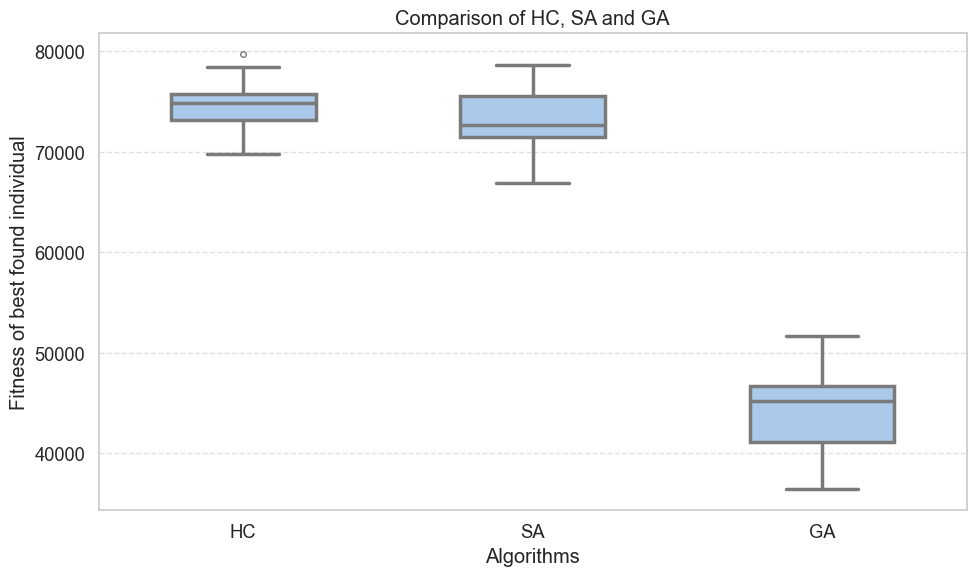

In [41]:
# Adicionar aos imports
import seaborn as sns
import matplotlib.pyplot as plt

# Create a DataFrame in long format
df = pd.DataFrame({
    'value': hc_best_fitnesses + sa_best_fitnesses + ga_best_fitnesses,
    'group': ['HC'] * len(hc_best_fitnesses) + ['SA'] * len(sa_best_fitnesses) + ['GA'] * len(ga_best_fitnesses)
})

# Set a beautiful theme
sns.set_theme(style="whitegrid", palette="pastel", font_scale=1.2)

# Create the plot
plt.figure(figsize=(10, 6))
ax = sns.boxplot(x='group', y='value', data=df, width=0.5, linewidth=2.5, fliersize=4)

# Titles and labels
plt.title('Comparison of HC, SA and GA')
plt.xlabel('Algorithms')
plt.ylabel('Fitness of best found individual')
plt.grid(True, axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()